In [2]:
#Following this walkthrough:
#https://www.kaggle.com/affjljoo3581/bms-molecular-translation-train-inchi-tokenizer
!pip install -qq -U allennlp transformers tokenizers

In [3]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Punctuation
from tokenizers.processors import TemplateProcessing
from tokenizers.decoders import WordPiece as WordPieceDecoder

In [4]:
samples = pd.read_csv('../data/train_labels.csv')
samples.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


In [5]:
tokenizer = Tokenizer(WordPiece(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Punctuation()

trainer = WordPieceTrainer(
    vocab_size=256, 
    min_frequency=2,
    special_tokens=['[UNK]', '[BOS]', '[EOS]', '[PAD]']
)
tokenizer.train_from_iterator(samples['InChI'], trainer=trainer)

In [6]:
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

In [7]:
print(' '.join(tokenizer.encode(samples.iloc[80000, 1]).tokens))
print(' '.join(tokenizer.encode(samples.iloc[53242, 1]).tokens))
print(' '.join(tokenizer.encode(samples.iloc[45212, 1]).tokens))
print(' '.join(tokenizer.encode(samples.iloc[782120, 1]).tokens))

[BOS] InChI = 1S / C21 ##H25 ##N3O2S / c1 - 5 - 6 - 16 - 13 - 18 ( 27 - 14 ( 16 ) 2 ) 21 ( 25 ) 23 - 19 ( 20 - 22 - 11 - 12 - 24 ( 20 ) 3 ) 15 - 7 - 9 - 17 ( 26 - 4 ) 10 - 8 - 15 / h7 - 13 , 19H , 5 - 6H2 , 1 - 4H3 , ( H , 23 , 25 ) [EOS]
[BOS] InChI = 1S / C12 ##H11 ##Br ##F2 ##N4O / c1 ##3 - 7 - 3 - 9 ( 15 ) 10 ( 4 - 8 ( 7 ) 14 ) 17 - 12 - 19 - 18 - 11 ( 20 - 12 ) 5 - 16 - 6 - 1 - 2 - 6 / h3 - 4 , 6 , 16H , 1 - 2 , 5H2 , ( H , 17 , 19 ) [EOS]
[BOS] InChI = 1S / C12 ##H22 ##N2O3 / c1 - 9 ( 15 ) 13 - 11 ( 12 ( 16 ) 17 ) 8 - 14 ( 2 ) 10 - 6 - 4 - 3 - 5 - 7 - 10 / h10 - 11H , 3 - 8H2 , 1 - 2H3 , ( H , 13 , 15 ) ( H , 16 , 17 ) [EOS]
[BOS] InChI = 1S / C20 ##H29 ##NO3 / c1 - 2 - 3 - 4 - 8 - 15 - 24 - 20 ( 23 ) 17 - 11 - 13 - 18 ( 14 - 12 - 17 ) 21 - 19 ( 22 ) 16 - 9 - 6 - 5 - 7 - 10 - 16 / h11 - 14 , 16H , 2 - 10 , 15H2 , 1H3 , ( H , 21 , 22 ) [EOS]


In [8]:
lengths = []
for inchi in tqdm.tqdm(samples['InChI']):
    lengths.append(len(tokenizer.encode(inchi).ids))

100%|██████████████████████████████████████████████████████████████████████| 2424186/2424186 [08:55<00:00, 4523.12it/s]


In [9]:
print(max(lengths))

317


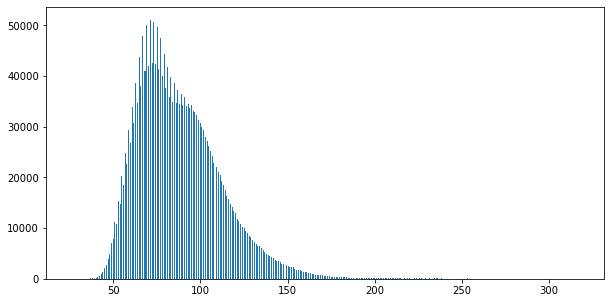

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=500)
plt.show()

In [11]:
tokenizer.decoder = WordPieceDecoder()
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("[PAD]"), pad_token='[PAD]', pad_to_multiple_of=8)
tokenizer.enable_truncation(max_length=256)

In [12]:
tokenizer.save('../data/tokenizer.json')